# Non-linear Regression Models

In this kernel, I want to explore non-linear models, mostly arising from linear models after basis expansions (polynomial, piecewice linear, splines, support vector regressions), but also tree methods.

I only perform basic feature engineering and the focus is on the models. There are many great kernels out there with very nice data exploration feature engineering, e.g. [this kernel](https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing#Feature-engineering).

In [182]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#!pip install -U pandas_profiling
import pandas_profiling
import warnings
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR 
import seaborn as sns
from scipy.stats import boxcox, skew
from pyearth import Earth
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [40]:
train_file_path = "../input/train.csv"
test_file_path = "../input/test.csv"
#kaggle:
#train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
#test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
df_train = pd.read_csv(train_file_path).drop(columns = ['Id'])
df_test = pd.read_csv(test_file_path)
test_Id = df_test['Id'] #for submission
df_test = df_test.drop(columns = ['Id'])

## Feature Engineering

### Outliers
We define outliers as those rows where a basic ridge model makes particularly bad predictions (see below after the ridge model, this is from [this kernel](https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions)).

In [41]:
outliers = [30, 88, 328, 410, 462, 495, 523, 588, 632, 688, 710, 728, 874, 916, 968, 970, 1298, 1324, 1432, 1453]
#outliers = [30, 88, 462, 523, 632, 1298, 1324]
df_train = df_train.drop(outliers).reset_index(drop=True)

### Remove features without enough data

In [42]:
frac = 0.8
missing_val_features = [(feature, df_train[feature].isnull().sum()/df_train.shape[0]) for feature in df_train.columns if df_train[feature].isnull().sum() >= frac*df_train.shape[0]]
#print(missing_val_features)
missing_val_features = [f for (f,i) in missing_val_features]
df_train = df_train.drop(missing_val_features,axis = 1)
df_test = df_test.drop(missing_val_features,axis = 1)

frac = 0.95
zero_val_features = [(feature, (df_train[feature] == 0).sum()/df_train.shape[0]) for feature in df_train.columns if (df_train[feature] == 0).sum() >= frac*df_train.shape[0]]
#print(zero_val_features)
zero_val_features = [f for (f,i) in zero_val_features]

df_train = df_train.drop(zero_val_features, axis = 1)
df_test = df_test.drop(zero_val_features, axis = 1)

### Transforming and adding some features

In [43]:
#Replace year with how much time has passed since

year_features = [feature for feature in df_train.columns if "Yr" in feature or "Year" in feature]
print(year_features)
new_names = ['Age', 'RemodAge','GarageAge', 'YrsSinceSell']
for i in range(4):
    feature, new_feature = year_features[i], new_names[i]
    
    df_train[feature].replace(0,np.nan)
    df_train.insert(0, new_feature, df_train[feature].max() - df_train[feature])
    df_train = df_train.drop(feature,axis=1)
    
    df_test[feature].replace(0,np.nan)
    df_test.insert(0, new_feature, df_test[feature].max() - df_test[feature])
    df_test = df_test.drop(feature,axis=1)
    
for df in [df_train, df_test]:
    df['Total_SF'] = (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])
    df['Age(House+Remod)'] = df['Age'] + df['RemodAge']
    #df['Total_SF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF'])
    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_porch_SF'] = (df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


### Variable type
We know split our features in categorical and numerical variables.
Some of the numerical features have very few unique values and should really be categorical instead.

['YrsSinceSell', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars']


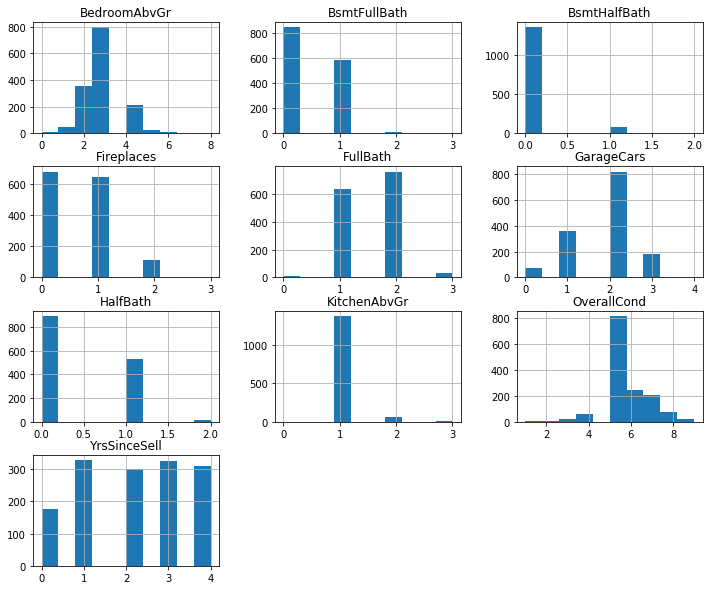

In [44]:
num_features = list(df_train.select_dtypes(include = 'number').columns)
thr = 10
cat_candidates = [feature for feature in num_features if df_train[feature].nunique() < thr]
print(cat_candidates)
hist = df_train[cat_candidates].hist(figsize = (12,10))

In [45]:
def group_values(df, bounds):
    """ Replaces the values of df by 0,...,len(bounds)
    so that values below bounds[0] will be 0, etc"""
    return df.apply(lambda x: sum(x >= np.array(bounds)))

for df in [df_train, df_test]:
    df['BsmtFullBath'] = group_values(df['BsmtFullBath'],[1])
    df['BsmtFullBath'] = df['BsmtFullBath'].astype(str)
    
    df['BsmtHalfBath'] = group_values(df['BsmtHalfBath'],[1])
    df['BsmtHalfBath'] = df['BsmtHalfBath'].astype(str)
    
    df['Fireplaces'] = group_values(df['Fireplaces'],[1,2])
    df['Fireplaces'] = df['Fireplaces'].astype(str)
    
    df['FullBath'] = group_values(df['FullBath'],[1,2,3])
    df['FullBath'] = df['FullBath'].astype(str)
    
    df['GarageCars'] = group_values(df['GarageCars'],[1,2,3])
    df['GarageCars'] = df['GarageCars'].astype(str)
    
    df['HalfBath'] = group_values(df['HalfBath'],[1])
    df['HalfBath'] = df['HalfBath'].astype(str)
    
    df['KitchenAbvGr'] = group_values(df['KitchenAbvGr'],[1])
    df['KitchenAbvGr'] = df['KitchenAbvGr'].astype(str)
    
    df['YrsSinceSell'] = group_values(df['YrsSinceSell'],[1,2,3,4])
    df['YrsSinceSell'] = df['YrsSinceSell'].astype(str)
    
    df['BedroomAbvGr'] = group_values(df['BedroomAbvGr'],[2,3,4,5])
    df['BedroomAbvGr'] = df['BedroomAbvGr'].astype(str)

### Splitting numerical and categorical features and filling in missing values

In [46]:
num_features = list(df_train.select_dtypes(include = 'number').columns)
num_features.remove('SalePrice')
cat_features = list(df_train.select_dtypes(include = 'object').columns)
features = list(df_train.columns)
features.remove('SalePrice')

print('There are', len(num_features), 'numerical features')
print('There are', len(cat_features), 'categorical features')
print('There are', len(features), 'features')

num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(df_train[num_features])
df_train[num_features] = num_imputer.transform(df_train[num_features])
df_test[num_features] = num_imputer.transform(df_test[num_features])
df_train[cat_features] = df_train[cat_features].fillna('None')
df_test[cat_features] = df_test[cat_features].fillna('None')

There are 27 numerical features
There are 48 categorical features
There are 75 features


### Fixing skewed features using boxcox

In [47]:
for feature in num_features:
    if skew(df_train[feature]) >= 0.5:
        df_train[feature], best_lambda = boxcox(1 + df_train[feature])
        df_test[feature] = boxcox(1 + df_test[feature], best_lambda)

### Creating dummies and removing features corresponding to rare values

In most models we need dummy variables for the categorical features. We will write this as an estimator so we can add it to the pipeline only when needed.

In [48]:
n_train = df_train.shape[0]
y = np.log(df_train['SalePrice'].values)
df_train = df_train.drop(['SalePrice'], axis=1)
df_all = pd.concat([df_train, df_test], axis=0)
df_all = pd.get_dummies(df_all)
df_train_dummies, df_test_dummies = df_all[:n_train], df_all[n_train:]

frac = 0.997
for feature in df_train_dummies.columns:
    zero_frac = (df_train_dummies[feature] == 0).sum()/n_train
    if (zero_frac >= frac):
        df_train_dummies = df_train_dummies.drop(feature, axis = 1)
        df_test_dummies = df_test_dummies.drop(feature, axis = 1)
        
X = df_train_dummies.values
num_cols = list(range(len(num_features)))
cat_cols = list(range(len(num_features),len(features)))

## Ordinary Least Squares Linear Regression

In [49]:
def rmse(y1, y2):
    return np.sqrt(mean_squared_error(y1, y2))

def rmse_model(model, X, y):
    y_pred = model.predict(X)
    return rmse(y,y_pred)

def examine_model(model, X, y, pipeline=False, features = [], coeffs=True):
    
    #X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3, shuffle=True)
    rmse_val = np.sqrt(-np.mean(cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv=5)))
    
    reg = model.fit(X, y)
    rmse_train = rmse_model(reg, X, y)
    print("Train RMSE: ", rmse_train, "Validation RMSE: ", rmse_val)
    
    if pipeline: reg = reg[-1]
    if features:
        coeffs = list(zip(features, reg.coef_))
        coeffs.sort(key = lambda tup: np.abs(tup[1]), reverse=True)
        print("Important Features: ", coeffs[:5])
        
    if coeffs:
        print(sum(1 for coeff in reg.coef_ if coeff==0), '/', len(reg.coef_), ' features are 0')

    return None

In [50]:
linear_model = LinearRegression()
examine_model(linear_model, X, y)

Train RMSE:  0.07509300775404287 Validation RMSE:  0.1456119929653874
0 / 262  features are 0


## Ridge Regression

In [51]:
alphas = [10, 30, 60, 100, 140, 190]
ridge_cv = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=5))
ridge_cv.fit(X,y)
best_alpha = ridge_cv[-1].alpha_
print('Best alpha: ', best_alpha)

ridge = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
examine_model(ridge, X, y, pipeline=True)

Best alpha:  30
Train RMSE:  0.07668954213719123 Validation RMSE:  0.09553074852461306
0 / 262  features are 0


## Outlier Detection

We use this model to find outliers. We fit the data on the whole training set, and remove examples which are predicted particularly bad. This idea is from here [this kernel](https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions).

In [52]:
#ridge.fit(X,y)
#predictions = ridge.predict(X)
#pred_error = y-predictions
#plt.boxplot(pred_error)
#thr = np.std(pred_error)*4.2
#mu = np.mean(pred_error)
#outliers = [i for i in range(pred_error.size) if np.abs(pred_error[i])-mu > thr]
#print(outliers)

## Lasso Regression

In [53]:
lasso_cv = make_pipeline(StandardScaler(), LassoCV(n_alphas=100, cv=5))
lasso_cv.fit(X,y)
best_alpha = lasso_cv[-1].alpha_
print('Best alpha: ', best_alpha)

lasso = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha))
examine_model(lasso, X, y, pipeline=True)

Best alpha:  0.0022876537159827828
Train RMSE:  0.08123598275197647 Validation RMSE:  0.09062072120307277
148 / 262  features are 0


## Elastic Net

In [54]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
net_cv = make_pipeline(StandardScaler(), ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, max_iter=3000))
net_cv.fit(X,y)
best_alpha_net = net_cv[-1].alpha_
print('Best alpha: ', best_alpha_net)
best_l1_ratio_net = net_cv[-1].l1_ratio_
print('Best l1_ratio: ', best_l1_ratio_net)

net = make_pipeline(StandardScaler(), ElasticNet(l1_ratio=best_l1_ratio_net, alpha=best_alpha_net, max_iter=6000))
examine_model(net, X, y, pipeline=True)

Best alpha:  0.004575307431965566
Best l1_ratio:  0.5
Train RMSE:  0.08126767792291228 Validation RMSE:  0.0906171983981969
145 / 262  features are 0


## Basis Expansion

We will now introduce non-linearity by adding new features which are non-linear functions of the old features.

Sklearn has two such models implemented kernel_ridge and Support Vector Machines for Regression. Both do not perform very well on this data (they are more suitable for more complex functions I suppose), so we will not go in detail.

In [171]:
kernel_ridge = make_pipeline(StandardScaler(), KernelRidge(kernel='poly', alpha=1))
examine_model(kernel_ridge, X, y, pipeline=True, coeffs=False)

Train RMSE:  0.03623775658846953 Validation RMSE:  0.11642749605538232


In [131]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10, epsilon=0.01, gamma=0.00025))
examine_model(svr, X, y, pipeline=True, coeffs=False)

Train RMSE:  0.050391186143154576 Validation RMSE:  0.09342446658926629


We will instead add new features, which are non-linear functions of the original features. We follow [Elements of Statistics, Chapter 5].

We begin with adding squares and cubes, thus fitting a cubic model. Unsurprisingly, we observe lower bias and higher variance (lower training error, but bigger difference between training and validation errror)

In [17]:
class BasisExpander(BaseEstimator, TransformerMixin):
    """
    Transforms the data by adding extra features of the form h(feature)
    for each basis expansion fucntion `h` and numerical feature `feature`
    """
    def __init__(self, numerical_columns, basis_exps):
        self.numerical_columns = numerical_columns
        self.basis_exps = basis_exps
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nr_basis_exps = len(self.basis_exps)
        X_num = X[:, self.numerical_columns]
        n, m = X_num.shape
        X_be = np.zeros((n, nr_basis_exps*m))

        for i,f in enumerate(self.basis_exps):
            X_be[:, i*m:(i+1)*m] = f(X_num)
        
        return np.concatenate([X, X_be], axis=1)

In [18]:
basis_exps = [lambda x: x**2, lambda x: x**3]
BE = BasisExpander(num_cols, basis_exps)
l1_ratios = [0.3, 0.5, 0.7, 0.9, 0.99]
net_cv = make_pipeline(BE, StandardScaler(), ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, max_iter=3000))
net_cv.fit(X,y)
best_alpha_be = net_cv[-1].alpha_
print('Best alpha: ', best_alpha_be)
best_l1_ratio_be = net_cv[-1].l1_ratio_
print('Best l1_ratio: ', best_l1_ratio_be)

net_be = make_pipeline(BE, StandardScaler(), ElasticNet(l1_ratio=best_l1_ratio_be, alpha=best_alpha_be, max_iter=6000))
examine_model(net_be, X, y, pipeline=True)

Best alpha:  0.002016219397088394
Best l1_ratio:  0.99
Train RMSE:  0.0795946290086268 Validation RMSE:  0.08987413584456613
182 / 316  features are 0


### Piecewise Models

We will now use basis expansions to allow for functions which are piecewise linear/cubic in each dimension. Note that such functions are more general and therefore we expect lower bias and higher variance. We follow [Elements of statistics, Chapter 5]. 

**Piecewise linear functions:**
Assume (for simplicity) that $X$ is one dimensional and let  $\min(X) = \xi_0, \ldots, \xi_k = \max(X)$ be a set of knots.

Let $h_1 = I(X<\xi_1)$, $h_i = I(\xi_{i-1} \leq X < \xi_i)$ for $i = 2, \ldots, k-1$, and $h_{k} = I(\xi_{k-1} \leq X)$, where $I$ denotes the indicator function which is $1$ if the condition is satisfied and $0$ otherwise. (Note that $h_1$ and $h_{k}$ look a little different so that we can make guesses for new data which exceeds the range of $X$). We then let $h_i'(X) = h_i(X) \cdot X$ for every $i = 0, \ldots, k$. It is easy to see that $\{h_0,h_0', \ldots, h_k,h_k'\}$ is a basis for all piecewise linear functions.

**Piecewise linear continuous functions:**
Piecewise linear functions can have quite big jumps and we would like to avoid this to reduce variance. Thus we need the extra conditions $f(\xi_i^-) = f(\xi_i^+)$ for all $i = 1, \ldots, k-1$ and each linear combination $f$ of $h_0, \ldots, h_k$. This would be annoying to deal with in our models. Luckily, there is the following equivalent way to achieve this:
Let $h_0 = 1$, $h_1(X) = X$, $h_{i+1}(X) = \max(X-\xi_i, 0)$ for all $i = 2, \ldots, k-1$. Then, $\{h_0, \ldots, h_{k-1}\}$ form a basis of all piecewise linear continuous functions. Note that the bias term in linear regression already gives us $h_0$, and $h_1$ is the original data, so we will not use those.

**Cubic Splines:**
A *cubic spline* is a continuous piecewise cubic polynomial with continuous with continuos first and second derivatives. It can be seen that  $h_0 = 1$, $h_1(X) = X$, $h_2(X) = X^2$, $h_3(X) = X^3$, and $h_{i+2}(X) = (\max(X-\xi_i, 0))^3$ for all $i = 2, \ldots, k-1$, define a basis for cubic splines. Again, we do not need $h_0$ due to the bias term.

**Natural Cubic Splines:**
A cubic spline can behave quite poorly outside the boundary. We can fix this by requiring linearity outside the boundary. This is called a *natural cubic spline*. For more details and the basis, see 'Elements of Statistics'. 

In [19]:
class PiecewiseBasisExpander(BaseEstimator, TransformerMixin):
    """
    Transforms the data by performing the necessary basis expansions for piecewise linear functions
    """
    def __init__(self, numerical_columns, nr_knots, model='pw-linear'):
        self.numerical_columns = numerical_columns
        self.nr_knots = nr_knots
        self.knots = None
        self.model = model
        
    def fit(self, X, y=None):
        k = self.nr_knots - 1
        X_num = X[:, self.numerical_columns]
        n, m = X_num.shape

        knots = np.zeros((self.nr_knots, m))
        knots[0,:] = np.min(X_num, axis=0)
        knots[-1,:] = np.max(X_num, axis=0)
        for i in range(1, k):
            knots[i,:] = knots[0,:] + (i/k) * (knots[-1,:] - knots[0,:])
        
        self.knots = knots
        return self
    
    def transform(self, X):
        k = self.nr_knots - 1
        X_num = X[:, self.numerical_columns]
        n, m = X_num.shape
        knots = self.knots
        
        if self.model == 'pw-linear':
            X_be = np.zeros((n, (k-1)*m))    
            for i in range(k-1):
                X_be[:, i*m:(i+1)*m] = np.maximum(X_num - knots[i+1,:], 0)
                
        if self.model == 'cubic-spline':
            X_be = np.zeros((n, (k+1)*m))
            X_be[:, :m] = X_num**2
            X_be[:, m:2*m] = X_num**3                         
            for i in range(1, k):
                X_be[:, (i+1)*m:(i+2)*m] = np.maximum(X_num - knots[i,:], 0)**3
                
        if self.model == 'natural-cubic-spline':
            X_be = np.zeros((n, (k+1)*m))

            d_last = (np.maximum(X_num-knots[k-1,:],0)**3 - np.maximum(X_num-knots[k,:],0)**3) / (knots[k,:] - knots[k-1,:])
            for i in range(1, k-1):
                d = (np.maximum(X_num-knots[i,:],0)**3 - np.maximum(X_num-knots[k,:],0)**3) / (knots[k,:] - knots[i,:])
                X_be[:, (i-1)*m:i*m] = d - d_last
                
        return np.concatenate([X, X_be], axis=1)

**Piecewise Linear**

In [20]:
BE_pwl = PiecewiseBasisExpander(num_cols, nr_knots=8)
l1_ratios = [0.3, 0.5, 0.7, 0.9, 0.99]
net_cv = make_pipeline(BE_pwl, StandardScaler(), ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, max_iter=3000))
net_cv.fit(X,y)
best_alpha_pwl = net_cv[-1].alpha_
print('Best alpha: ', best_alpha_pwl)
best_l1_ratio_pwl = net_cv[-1].l1_ratio_
print('Best l1_ratio: ', best_l1_ratio_pwl)

net_pwl = make_pipeline(BE_pwl, StandardScaler(), ElasticNet(l1_ratio=best_l1_ratio_pwl, alpha=best_alpha_pwl, max_iter=6000))
examine_model(net_pwl, X, y, pipeline=True)

Best alpha:  0.003509305069266093
Best l1_ratio:  0.7
Train RMSE:  0.07904665894489431 Validation RMSE:  0.08994494758166433
293 / 424  features are 0


**Cubic Spline**

In [21]:
BE_cs = PiecewiseBasisExpander(num_cols, nr_knots=6, model='cubic-spline')
l1_ratios = [0.3, 0.5, 0.7, 0.9, 0.99]
net_cv = make_pipeline(BE_cs, StandardScaler(), ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, max_iter=3000))
net_cv.fit(X,y)
best_alpha_cs = net_cv[-1].alpha_
print('Best alpha: ', best_alpha_cs)
best_l1_ratio_cs = net_cv[-1].l1_ratio_
print('Best l1_ratio: ', best_l1_ratio_cs)

net_cs = make_pipeline(BE_cs, StandardScaler(), ElasticNet(l1_ratio=best_l1_ratio_cs, alpha=best_alpha_cs, max_iter=6000))
examine_model(net_cs, X, y, pipeline=True)

Best alpha:  0.003278543903569135
Best l1_ratio:  0.7
Train RMSE:  0.079064783816327 Validation RMSE:  0.090015054232259
287 / 424  features are 0


**Natural Cubic Spline**

In [22]:
BE_ncs = PiecewiseBasisExpander(num_cols, nr_knots=4, model='natural-cubic-spline')
l1_ratios = [0.3, 0.5, 0.7, 0.9, 0.99]
net_cv = make_pipeline(BE_ncs, StandardScaler(), ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=5, max_iter=3000))
net_cv.fit(X,y)
best_alpha_ncs = net_cv[-1].alpha_
print('Best alpha: ', best_alpha_ncs)
best_l1_ratio_ncs = net_cv[-1].l1_ratio_
print('Best l1_ratio: ', best_l1_ratio_ncs)

net_ncs = make_pipeline(BE_ncs, StandardScaler(), ElasticNet(l1_ratio=best_l1_ratio_ncs, alpha=best_alpha_ncs, max_iter=6000))
examine_model(net_ncs, X, y, pipeline=True)

Best alpha:  0.0024777536312711617
Best l1_ratio:  0.99
Train RMSE:  0.08043339618178388 Validation RMSE:  0.08955036378563551
251 / 370  features are 0


## Multivariate Adaptive Regression Splines (MARS)

The Mars algorithm fits a linear combination of (in this case 1d but higher orders are possible as well) splines automatically selecting features and knots. I am surprised that it doesn't perform better. My best bet is that it struggles with the dummies which we ignored for higher order terms above.

In [174]:
mars = make_pipeline(StandardScaler(), Earth(max_degree=1))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    examine_model(mars, X, y, coeffs=False, pipeline=True)
#mars = mars.fit(X,y)

Train RMSE:  0.09073331405565027 Validation RMSE:  0.09648396408242432


## Tree methods

Both gradient boosting and random forests are not extremely good on this data, but help with blending later.

In [187]:
    catboost = CatBoostRegressor(logging_level='Silent', allow_writing_files=False)
examine_model(catboost, X, y, coeffs=False)

Train RMSE:  0.03288845394758331 Validation RMSE:  0.09579993618321168


In [25]:
rf = RandomForestRegressor()
examine_model(rf, X, y, coeffs=False)

Train RMSE:  0.045117993093895636 Validation RMSE:  0.12097151419745879


## Stacking

In [200]:
estimators = [('net', net), ('svr', svr), ('net_pwl', net_pwl), ('net_ncs', net_ncs), ('catboost', catboost)]
stacked_model = StackingRegressor(estimators=estimators, final_estimator=Lasso(alpha=0, positive=True))
examine_model(stacked_model, X, y, coeffs=False)

Train RMSE:  0.05951015347470518 Validation RMSE:  0.08819949325826598


## Submission

In [29]:
stacked_model = stacked_model.fit(X,y)
X_test = df_test_dummies.values
predictions = np.exp(stacked_model.predict(X_test))
my_submission = pd.DataFrame({'Id': test_Id, 'SalePrice': predictions})
my_submission.to_csv('submission.csv', index=False)

In [30]:
my_submission

,Id,SalePrice
0,1461,126269.113692
1,1462,161803.575375
2,1463,186866.064140
3,1464,198926.545027
4,1465,186557.713467
...,...,...
1454,2915,87780.114303
1455,2916,82871.995277
1456,2917,172827.942193
1457,2918,119951.866219
